In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam, LBFGS # Optimizer imports

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# ==============================================================================
# 0. GLOBAL CONFIGURATION AND HYPERPARAMETERS
# ==============================================================================

# Device setting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Physical/Domain Parameters
x_if = 0.5                              # Interface location
L = 1.0                                 # Total domain length (0 to 1)
n = 1                                   # Parameter for initial condition (sin(n*pi*x/L))
alpha = 0.1                             # Thermal diffusivity (Example value)


# Sampling Points
N_int = 8000                            # Collocation points (PDE)
N_b = 400                               # Boundary points (BC)
N_0 = 400                               # Initial condition points (IC)
N_if = 800                              # Interface points (IF)

# Training Parameters
epochs_adam = 8000
print_every = 500
lr_adam = 1e-3                          # Adam Optimizer learning rate

# Loss Weights (Adjusted weights for better convergence in boundary-heavy problems)
W_PDE = 1
W_BC  = 5
W_IC  = 5
W_IF  = 5

# ==============================================================================
# 1. NETWORK DEFINITION (PINN Class)
# ==============================================================================

class PINN(nn.Module):
    def __init__(self, layers=(2, 128, 128, 128, 1)):
        super(PINN, self).__init__()

        # --- 1. Network Architecture Construction ---
        seq = []
        for i in range(len(layers) - 2):
            seq.append(nn.Linear(layers[i], layers[i+1]))
            seq.append(nn.Tanh())

        # Final output layer
        seq.append(nn.Linear(layers[-2], layers[-1]))

        # Combine and move to device
        self.net = nn.Sequential(*seq).to(device)

        # --- 2. Weight Initialization ---
        self._initialize_weights()

    def _initialize_weights(self):
        for p in self.net.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x):
        return self.net(x)

# ==============================================================================
# 2. SAMPLING AND RESIDUAL FUNCTIONS
# ==============================================================================

def sampler(N, x_min, x_max):
    """Sample x uniformly in [x_min, x_max) and t uniformly in [0, 1)"""
    x = (x_max - x_min) * torch.rand(N, 1) + x_min
    t = torch.rand(N, 1)
    return x.to(device), t.to(device)

def time_sampler(N):
    """Sample time t uniformly in [0, 1)"""
    return torch.rand(N, 1).to(device)

def initial_sampler(N, x_min, x_max):
    """Sample x and set time t=0"""
    x = (x_max - x_min) * torch.rand(N, 1) + x_min
    t = torch.zeros_like(x)
    return x.to(device), t.to(device)

def pde_residual(net, x, t):
    """Calculates the residual of the 1D Heat Equation: du/dt - alpha * d2u/dx2"""
    x.requires_grad_(True)
    t.requires_grad_(True)

    # Forward pass
    u = net(torch.cat((x, t), 1))

    # Calculate derivatives using torch.autograd.grad
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]

    # PDE Residual
    residual = u_t - alpha * u_xx

    return residual

# ==============================================================================
# 3. LOSS FUNCTIONS
# ==============================================================================

def loss_pde(netL, netR):
    """Loss from the PDE residual."""
    xL, tL = sampler(N_int, 0, x_if)
    res_L = pde_residual(netL, xL, tL).pow(2).mean()
    xR, tR = sampler(N_int, x_if, L)
    res_R = pde_residual(netR, xR, tR).pow(2).mean()
    return res_L + res_R

def loss_bc(netL, netR):
    """Loss from Dirichlet Boundary Conditions (u=0 at x=0, x=L)."""
    t_b = time_sampler(N_b)
    # x=0 boundary (Left)
    bc_L = netL(torch.cat((torch.zeros_like(t_b), t_b), 1)).pow(2).mean()
    # x=L boundary (Right)
    bc_R = netR(torch.cat((torch.full_like(t_b, L), t_b), 1)).pow(2).mean()
    return bc_L + bc_R

def loss_ic(netL, netR):
    """Loss from Initial Condition (t=0). u(x, 0) = sin(n*pi*x/L)"""
    x0L, t0L = initial_sampler(N_0, 0, x_if)
    ic_L = (netL(torch.cat((x0L, t0L), 1)) - torch.sin(n * np.pi * x0L / L)).pow(2).mean()
    x0R, t0R = initial_sampler(N_0, x_if, L)
    ic_R = (netR(torch.cat((x0R, t0R), 1)) - torch.sin(n * np.pi * x0R / L)).pow(2).mean()
    return ic_L + ic_R

def loss_interface(netL, netR):
    """Loss from Interface Continuity (uL=uR and du/dxL=du/dxR) at x=x_if."""

    # Sample time points (t_if) uniformly across the time domain [0, T]
    t_if = time_sampler(N_if)

    # Create the tensor representing the interface x-coordinate (x_if) for all sampled time points.
    x_if_tensor = torch.full_like(t_if, x_if).to(device)

    # Value continuity (uL = uR)
    x_ifL_val = x_if_tensor.clone()
    x_ifL_val.requires_grad_(False)
    x_ifR_val = x_if_tensor.clone()
    x_ifR_val.requires_grad_(False)

    # Perform the forward pass for the Left/Right networks (netL/netR) using the combined [x, t] inputs.
    uL = netL(torch.cat((x_ifL_val, t_if), 1))
    uR = netR(torch.cat((x_ifR_val, t_if), 1))

    # Mean Squared Error (MSE) loss for Value Continuity: (uL - uR)^2.
    # Minimizing this forces uL to be equal to uR at the interface points.
    cont_val = (uL - uR).pow(2).mean()

    # Flux continuity (du/dxL = du/dxR)
    # Clone the base x_if_tensor for the Left network's flux evaluation.
    x_ifL_flux = x_if_tensor.clone()
    # (du/dx) with respect to this tensor using Autograd.
    x_ifL_flux.requires_grad_(True)

    x_ifR_flux = x_if_tensor.clone()
    x_ifR_flux.requires_grad_(True)

    # Forward pass to get u values (uL_flux / uR_flux) needed for du/dx calculation.
    uL_flux = netL(torch.cat((x_ifL_flux, t_if), 1))
    uR_flux = netR(torch.cat((x_ifR_flux, t_if), 1))

    # Compute the derivative du/dx for the Left/Right networks (uL_dx / uR_dx).
    # - inputs = x_ifL_flux: Specifies the variable (x) to differentiate with respect to.
    # - grad_outputs=torch.ones_like(uL_flux): Required because uL_flux is not a scalar.
    # - create_graph=True: Required to calculate second-order derivatives (used in the
    #   overall loss backward pass and optimization).
    uL_dx = torch.autograd.grad(uL_flux, x_ifL_flux, torch.ones_like(uL_flux), create_graph=True)[0]
    uR_dx = torch.autograd.grad(uR_flux, x_ifR_flux, torch.ones_like(uR_flux), create_graph=True)[0]

    cont_flux = (uL_dx - uR_dx).pow(2).mean()

    return cont_val + cont_flux

def total_loss_fn(netL, netR):
    """Aggregates all individual loss components with their respective weights."""

    L_PDE = loss_pde(netL, netR)
    L_BC = loss_bc(netL, netR)
    L_IC = loss_ic(netL, netR)
    L_IF = loss_interface(netL, netR)

    # Total weighted loss
    total_loss = (W_PDE * L_PDE) + (W_BC * L_BC) + \
                 (W_IC * L_IC) + (W_IF * L_IF)

    return total_loss, L_PDE, L_BC, L_IC, L_IF

# ==============================================================================
# 4. MODEL INSTANTIATION AND TRAINING SETUP
# ==============================================================================

netL = PINN().to(device) # Network for the Left domain
netR = PINN().to(device) # Network for the Right domain

# Combine parameters from both networks for the optimizer
params = list(netL.parameters()) + list(netR.parameters())

# Adam Optimizer initialization
opt_adam = Adam(params, lr=lr_adam)


# ==============================================================================
# 5. ADAM OPTIMIZATION (PRE-TRAINING)
# ==============================================================================

print("--- Starting Adam Optimization (Pre-training) ---")
for ep in range(1, epochs_adam + 1):
    opt_adam.zero_grad()

    # -------------------------------------------------------------------------
    # Forward Pass and Total Loss Calculation
    # Executes the forward pass of both netL and netR on sampled collocation points.
    # The total_loss_fn encapsulates all physical constraints:
    # - L_PDE: Physics Loss (Residual of the Heat Equation)
    # - L_BC: Boundary Condition Loss (e.g., u=0 at x=0, x=L)
    # - L_IC: Initial Condition Loss (u(x, 0) = Initial State)
    # - L_IF: Interface Continuity Loss (uL=uR, du/dxL=du/dxR at the domain split point)
    # l_total is the weighted sum of these individual losses.
    l_total, l_pde, l_bc, l_ic, l_if = total_loss_fn(netL, netR)

    # -------------------------------------------------------------------------
    # Backpropagation (Gradient Calculation)
    # Initiates the backward pass using PyTorch's Autograd engine.
    # This computes the partial derivative of the total loss (l_total) with respect
    # to every trainable parameter (weights and biases) in netL and netR.
    # The calculated gradients (dL/dW) are stored in the '.grad' attribute of each parameter Tensor.
    l_total.backward()

    # -------------------------------------------------------------------------
    # The Adam optimizer uses the calculated gradients (from l_total.backward())
    # to update the model parameters according to the Adam algorithm (Adaptive Moment Estimation).
    # This is where the weights and biases are actually adjusted to minimize the total loss.
    opt_adam.step()

    # Logging and Printing
    if ep % print_every == 0:
        print(f"Epoch {ep:5d} | Total Loss={l_total.item():.3e} | PDE={l_pde.item():.3e} | BC={l_bc.item():.3e} | IC={l_ic.item():.3e} | IF={l_if.item():.3e}")

print("Adam Optimization finished.")

# ==============================================================================
# 6. L-BFGS OPTIMIZATION (REFINEMENT)
# ==============================================================================

print("\n--- Starting LBFGS Refinement ---")

# LBFGS Optimizer initialization
lbfgs = LBFGS(params,
              lr=1.0,
              max_iter=500,
              max_eval=500,
              tolerance_grad=1e-8,
              tolerance_change=1e-9,
              history_size=200,
              line_search_fn="strong_wolfe")

# Counter for LBFGS printing
lbfgs_step_counter = 0

def lbfgs_closure_with_print():
    """LBFGS closure function with printing logic."""
    global lbfgs_step_counter
    lbfgs_step_counter += 1

    lbfgs.zero_grad()

    l_total, l_pde, l_bc, l_ic, l_if = total_loss_fn(netL, netR)

    l_total.backward()

    if lbfgs_step_counter % 50 == 0:
        print(f"LBFGS Step {lbfgs_step_counter:3d} | Total Loss={l_total.item():.3e} | PDE={l_pde.item():.3e}")

    return l_total

# Run LBFGS optimization
lbfgs.step(lbfgs_closure_with_print)

# Final loss calculation after optimization
final_loss_tensor = lbfgs.step(lbfgs_closure_with_print)
print(f"LBFGS Optimization finished. Final loss = {final_loss.item():.3e}")

--- Starting Adam Optimization (Pre-training) ---


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch   500 | Total Loss=3.740e-02 | PDE=1.909e-02 | BC=1.627e-03 | IC=9.403e-04 | IF=1.094e-03
Epoch  1000 | Total Loss=3.585e-02 | PDE=2.391e-03 | BC=5.249e-04 | IC=2.778e-04 | IF=5.889e-03
Epoch  1500 | Total Loss=1.847e-01 | PDE=1.684e-03 | BC=2.772e-03 | IC=1.921e-03 | IF=3.191e-02
Epoch  2000 | Total Loss=1.567e-03 | PDE=1.212e-03 | BC=9.384e-06 | IC=3.670e-05 | IF=2.498e-05
Epoch  2500 | Total Loss=1.239e-02 | PDE=1.602e-03 | BC=1.338e-04 | IC=1.973e-04 | IF=1.827e-03
Epoch  3000 | Total Loss=1.057e-02 | PDE=8.412e-04 | BC=1.473e-04 | IC=8.189e-05 | IF=1.716e-03
Epoch  3500 | Total Loss=4.934e-03 | PDE=1.219e-03 | BC=3.988e-05 | IC=1.037e-04 | IF=5.995e-04
Epoch  4000 | Total Loss=7.938e-04 | PDE=6.416e-04 | BC=4.716e-06 | IC=1.207e-05 | IF=1.366e-05
Epoch  4500 | Total Loss=3.259e-03 | PDE=1.780e-03 | BC=9.166e-05 | IC=1.705e-04 | IF=3.369e-05
Epoch  5000 | Total Loss=1.866e-03 | PDE=6.122e-04 | BC=4.370e-05 | IC=6.166e-05 | IF=1.455e-04
Epoch  5500 | Total Loss=8.527e-04 | PDE

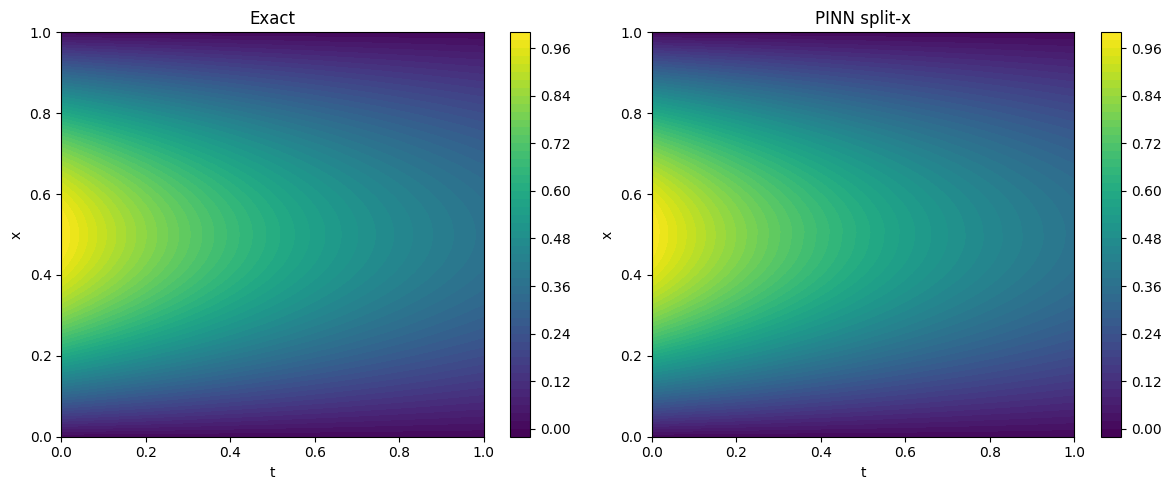

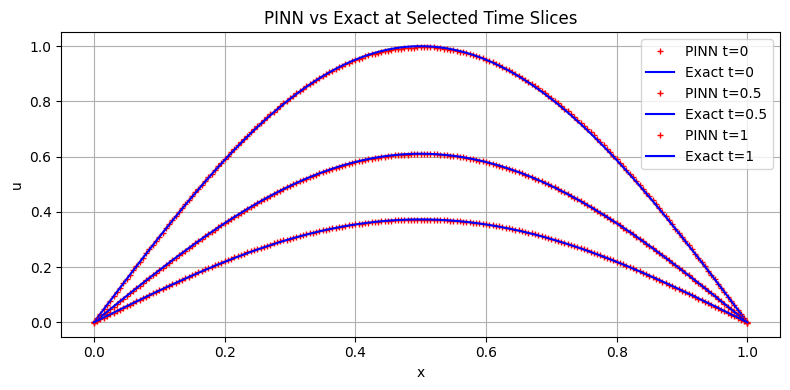

In [ ]:
import matplotlib.pyplot as plt

# Exact solution
def u_exact(x, t):
    """Calculates the analytical solution for the 1D Heat Equation with IC sin(n*pi*x/L)."""
    # The solution is a product of exponential decay in time and a sine wave in space.
    return np.exp(-n**2 * np.pi**2 * alpha * t / L**2) * np.sin(n * np.pi * x / L)


# Define the grid resolution for visualization
Nx, Nt = 201, 201

# Create uniformly spaced 1D tensors for position (x) and time (t)
xg = torch.linspace(0, 1, Nx, device=device)
tg = torch.linspace(0, 1, Nt, device=device)

# Create a 2D meshgrid (X, T) from the 1D tensors
X, T = torch.meshgrid(xg, tg, indexing="ij")

# --- Model Prediction on the Grid ---
with torch.no_grad():
    # Stack X and T into an input tensor of shape (Nx*Nt, 2)
    inp = torch.stack((X.flatten(), T.flatten()), 1)

    # Create a boolean mask to separate points for netL (x <= x_if)
    mask = (X.flatten() <= x_if)

    # Initialize the prediction tensor with zeros
    u_pred = torch.zeros_like(X.flatten()).unsqueeze(1)

    # Predict solution using netL for the left domain (where mask is True)
    u_pred[mask]  = netL(inp[mask])

    # Predict solution using netR for the right domain (where mask is False, i.e., ~mask)
    u_pred[~mask] = netR(inp[~mask])

    # Reshape the prediction tensor back to the 2D grid shape (Nx, Nt) and convert to NumPy for plotting
    U_pred = u_pred.view(Nx, Nt).cpu().numpy()

# Calculate the exact solution on the same grid for comparison
U_exact = u_exact(X.cpu().numpy(), T.cpu().numpy())


# --- Contour Plot Visualization (x-t plane) ---
fig = plt.figure(figsize=(12, 5))

# Subplot 1: Exact Solution
ax1 = fig.add_subplot(1, 2, 1)
cf = ax1.contourf(T.cpu(), X.cpu(), U_exact, 50) # Plot U_exact as a contour map
fig.colorbar(cf, ax=ax1)
ax1.set_title("Exact")
ax1.set_xlabel("t")
ax1.set_ylabel("x")

# Subplot 2: PINN Prediction
ax2 = fig.add_subplot(1, 2, 2)
cf2 = ax2.contourf(T.cpu(), X.cpu(), U_pred, 50) # Plot U_pred (split domain)
fig.colorbar(cf2, ax=ax2)
ax2.set_title("PINN split-x")
ax2.set_xlabel("t")
ax2.set_ylabel("x")

plt.tight_layout() # Adjust layout for better fit
plt.show()


# --- Function for Plotting Time Slices (1D Cuts) ---
def plot_cut(t_val, label):
    """Plots the solution u(x, t_val) as a function of x at a fixed time t_val."""

    # Create x-coordinates tensor (Nx, 1)
    x = xg.unsqueeze(1)
    # Create time tensor (t_val) corresponding to all x-coordinates
    t = torch.full_like(x, t_val).to(device)

    with torch.no_grad():
        # Predict the solution u(x, t_val) using torch.where to select netL or netR based on x_if
        up = torch.where(x <= x_if,
                         netL(torch.cat((x, t), 1)), # Use netL for x <= x_if
                         netR(torch.cat((x, t), 1))) # Use netR for x > x_if

    # PINN Prediction Plot: red markers
    plt.plot(x.cpu(), up.cpu(), 'r+', markersize=4, label=f"PINN {label}")

    # Exact Solution Plot: blue solid line
    plt.plot(x.cpu(), u_exact(x.cpu().numpy(), np.full_like(x.cpu().numpy(), t_val)),
             'b-', linewidth=1.5, label=f"Exact {label}")


# --- Plotting Selected Time Slices ---
plt.figure(figsize=(8, 4))

# Plot cuts at specific time instances
plot_cut(0.0, 't=0')   # Initial condition comparison
plot_cut(0.5, 't=0.5') # Mid-time comparison
plot_cut(1.0, 't=1')   # Final time comparison

plt.xlabel("x")
plt.ylabel("u")
plt.title("PINN vs Exact at Selected Time Slices")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()